In [29]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.sparse

## Question 6 - Generating Dictionary Tables

In [36]:
# Load the pickle file
with open('top30_by_genre.pkl', 'rb') as f:
    genre_dict = pickle.load(f)

#### 
We focus on the genres 
1. Romance 
2. Adventure 
3. Biography 
4. Fantasy 

We want to display the top 30 termsby TF-IDF score for each of these genres side by side. The intuition we have is that the terms in these dictionaries should be clear indicators of their genre. We should be able to tell what genre a term belongs to by looking at the top 30 terms appearing by the TF-IDF score. 

In [ ]:
# List the genres to compare 
desired_genres = ['romance', 'adventure', 'biography', 'fantasy']

# For each desired genre, extract the top 10 terms (by aggregated TF-IDF score)
top_terms = {}
for genre in desired_genres:
    # Check if the genre exists in the dictionary 
    if genre in genre_dict:
        # Sort the terms by score descending
        sorted_terms = sorted(genre_dict[genre].items(), key=lambda x: x[1], reverse=True)
        # Get the top 30 terms (just the term names, ignoring scores)
        top_terms[genre] = [term for term, score in sorted_terms[:30]]
    else:
        top_terms[genre] = []

# Pad the lists so they are all the same length (for display purposes)
max_len = max(len(lst) for lst in top_terms.values())
for genre in top_terms:
    if len(top_terms[genre]) < max_len:
        top_terms[genre].extend([None] * (max_len - len(top_terms[genre])))

# Create a df with genres as columns and rows as the rank (1st term, 2nd term, etc.)
df_top_terms = pd.DataFrame(top_terms)
df_top_terms.index = [f"Rank {i+1}" for i in range(max_len)]

print(df_top_terms)

# Convert to a LaTeX table 
latex_table = df_top_terms.to_latex(index=True, na_rep='', caption="Top 30 Terms by Genre", label="tab:top_terms", float_format="%.3f")

# Ask gpt to format this in a beautiful way
print(latex_table)


            romance   adventure   biography     fantasy
Rank 1       kissed      nodded     william      nodded
Rank 2       madame      stared          dr      stared
Rank 3     mistress       cabin     british      palace
Rank 4       honour  shook head       troop       maybe
Rank 5         aunt      paused       henry       giant
Rank 6        paris        deck   political      paused
Rank 7       paused     glanced      german  shook head
Rank 8       nodded         lad    national        cave
Rank 9      glanced       swung   president       magic
Rank 10      stared        crew       paris        grey
Rank 11     said mr        rode     charles        tiny
Rank 12  shook head       cliff    military     glanced
Rank 13      cousin       fired       james      castle
Rank 14       hotel    muttered        poet        lake
Rank 15    charming       maybe       april     staring
Rank 16    murmured      jumped       honor      anyone
Rank 17      colour     staring        june    p

In [4]:
df_dtm = pd.read_csv('dtm_with_genres.csv', index_col=0)
df_dtm.head()

,aaron,ab,aback,abandon,abandoned,abandoning,abandonment,abasement,abashed,abate,...,zealand,zealous,zealously,zenith,zephyr,zero,zest,zigzag,zone,genres
0,0.0,0.0,0.032537,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,"['literature', 'read-for-school', 'classics', ..."
1,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.013291,0.009549,0.000000,...,0.0,0.000000,0.0,0.010766,0.0,0.0,0.000000,0.0,0.000000,"['literature', 'mystery', 'speculative-fiction..."
2,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.009385,0.0,0.009709,"['school', 'non-fiction', 'literary-fiction', ..."
3,0.0,0.0,0.000000,0.000000,0.005152,0.000000,0.0,0.000000,0.000000,0.010075,...,0.0,0.008131,0.0,0.015832,0.0,0.0,0.000000,0.0,0.008626,"['speculative-fiction', '20th-century', 'scien..."
4,0.0,0.0,0.000000,0.013656,0.011962,0.019864,0.0,0.000000,0.019257,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,"['literature', 'read-for-school', 'school', 'c..."


## Question 7: Computing Interesting Things With the Dictionaries

In [55]:
original_corpus = pd.read_csv('clean_data.csv', index_col=0)
print(original_corpus.head())

                         title  \
0              apocolocyntosis   
1  the house on the borderland   
2                 the warriors   
3         a voyage to the moon   
4                 la fiammetta   

                                                text  \
0  Produced by Ted Garvin, Ben Courtney and PG Di...   
1  Produced by Suzanne Shell, Sjaani and PG Distr...   
2  Produced by Charles Aldarondo, Charlie Kirschn...   
3  Produced by Christine De Ryck, Stig M. Valstad...   
4  Produced by Ted Garvin, Dave Morgan and PG Dis...   

                                              genres lang  
0  {'21st-century', 'history', 'roman', 'classics...   en  
1  {'horror', 'mystery', 'classics', 'science-fic...   en  
2  {'literary-fiction', 'history', 'biography', '...   en  
3  {'20th-century', 'science-fiction', 'speculati...   en  
4  {'literary-fiction', 'history', 'feminism', 'c...   en  


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import ast

def convert_genres(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except Exception:
            return [x]
    elif isinstance(x, list):
        return x
    else:
        return [x]

original_corpus['genres'] = original_corpus['genres'].apply(convert_genres)

# Create a CountVectorizer to get raw term frequencies.
vectorizer = CountVectorizer(stop_words='english',
                             min_df=0.05,   # ignore terms in <5% of docs
                             max_df=0.5,    # ignore terms in >50% of docs
                             max_features=5000)
X_count = vectorizer.fit_transform(original_corpus['text'])
terms = vectorizer.get_feature_names_out()

# Build a DataFrame from the document-term matrix.
dtm_count = pd.DataFrame(X_count.toarray(), columns=terms)
# Append the genres column (order is preserved)
dtm_count['genres'] = original_corpus['genres'].values

# --- Step 2: Overall Aggregated Term Frequencies ---
# Sum raw counts for each term across the entire corpus.
overall_counts = dtm_count[terms].sum()

# Convert to a long-format DataFrame for plotting.
overall_counts_long = overall_counts.reset_index()
overall_counts_long.columns = ['Term', 'Frequency']

plt.figure(figsize=(12,6))
sns.histplot(overall_counts_long['Frequency'], bins=50, kde=True)
plt.title("Overall Term Frequency Distribution in the Corpus")
plt.xlabel("Raw Frequency")
plt.ylabel("Number of Terms")
plt.tight_layout()
plt.show()

# --- Step 3: Aggregated Term Frequencies by Genre ---
# For each document, define a "primary genre". If a document has multiple genres, just choose the first one 
dtm_count['primary_genre'] = dtm_count['genres'].apply(lambda x: x[0] if isinstance(x, list) and len(x) > 0 else None)

# Group documents by primary genre and sum term counts.
genre_counts = dtm_count.groupby('primary_genre')[terms].sum()

# Convert the genre-level counts DataFrame into long format.
genre_counts_long = genre_counts.reset_index().melt(id_vars='primary_genre', 
                                                     var_name='Term', 
                                                     value_name='Frequency')

# filter out terms that didn't appear (frequency = 0).
genre_counts_long = genre_counts_long[genre_counts_long['Frequency'] > 0]

plt.figure(figsize=(14,8))
sns.boxplot(x='primary_genre', y='Frequency', data=genre_counts_long, palette="Set3")
plt.title("Term Frequency Distributions by Genre")
plt.xlabel("Genre")
plt.ylabel("Aggregated Raw Frequency")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


KeyboardInterrupt: 

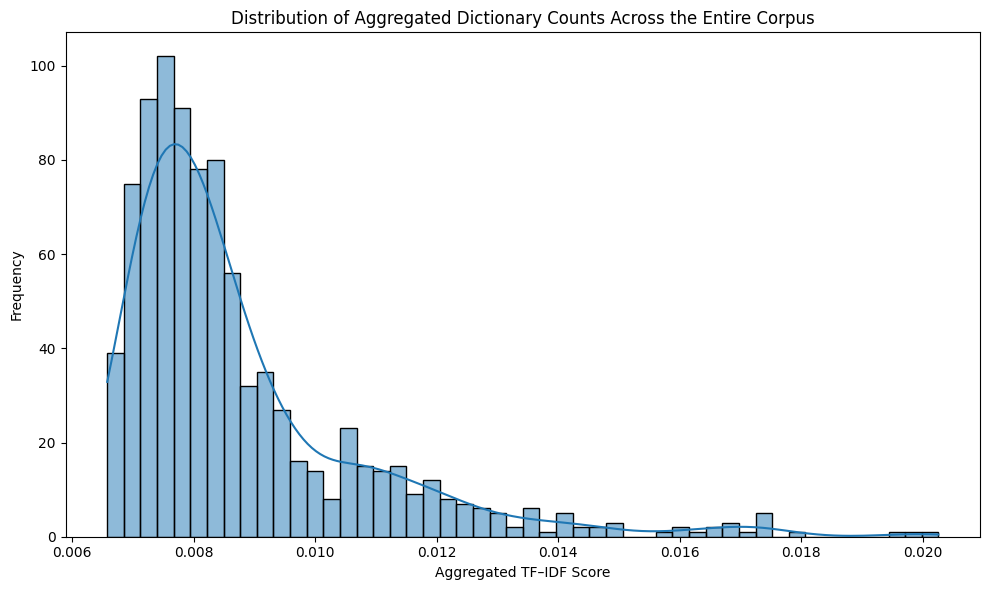

/var/folders/xk/dkwzfs8166d33myhj68mxhzh0000gn/T/ipykernel_51055/2139881390.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genre', y='Score', data=df_long, palette="Set3")


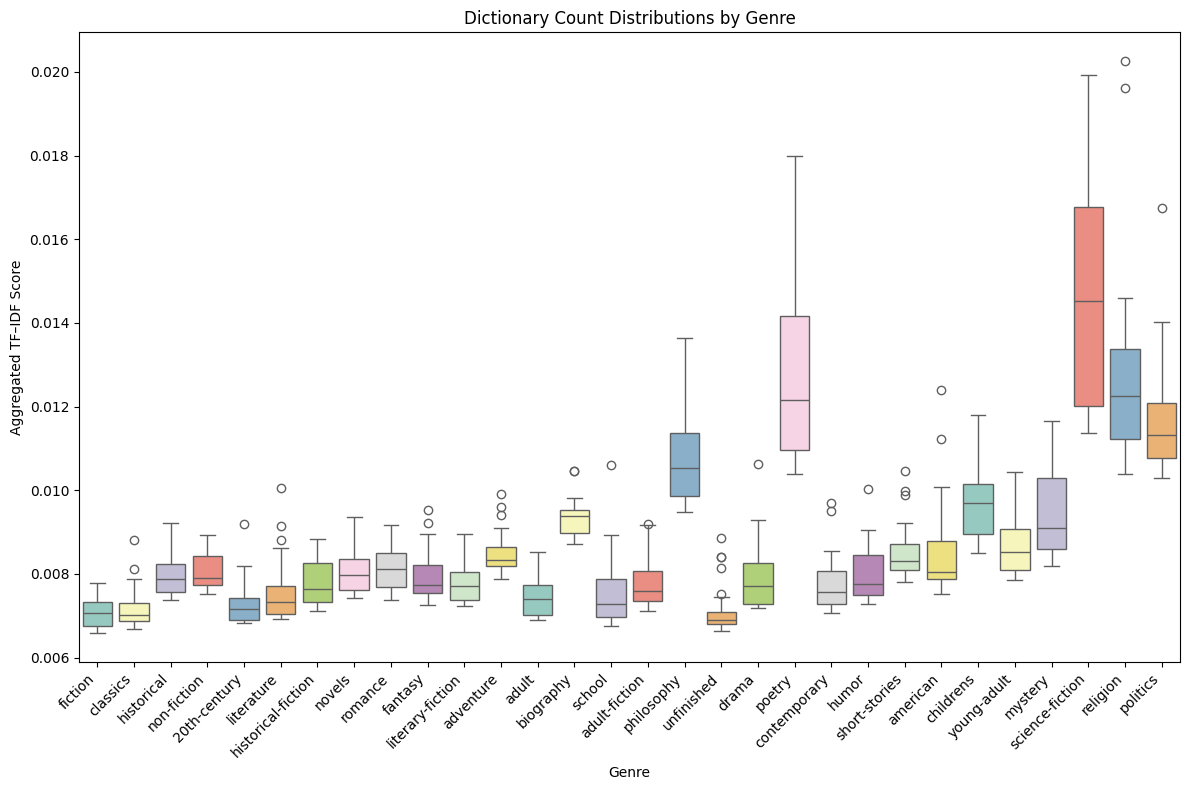

Summary statistics of aggregated scores by Genre:
                    count      mean       std       min       25%       50%  \
Genre                                                                         
20th-century         30.0  0.007279  0.000508  0.006828  0.006889  0.007159   
adult                30.0  0.007440  0.000464  0.006894  0.007011  0.007394   
adult-fiction        30.0  0.007818  0.000637  0.007101  0.007347  0.007584   
adventure            30.0  0.008487  0.000498  0.007888  0.008188  0.008328   
american             30.0  0.008543  0.001096  0.007515  0.007889  0.008054   
biography            30.0  0.009328  0.000451  0.008719  0.008981  0.009391   
childrens            30.0  0.009697  0.000848  0.008498  0.008963  0.009686   
classics             30.0  0.007154  0.000465  0.006688  0.006878  0.007009   
contemporary         30.0  0.007772  0.000674  0.007071  0.007285  0.007566   
drama                30.0  0.007841  0.000740  0.007175  0.007289  0.007703   
fa

In [59]:
# Load the aggregated dictionaries for the top 30 genres
with open('top30_by_genre.pkl', 'rb') as f:
    genre_dict = pickle.load(f)

# Convert the dictionary into a DataFrame with genres as rows and terms as columns.
df_top30 = pd.DataFrame.from_dict(genre_dict, orient='index')
df_top30.index.name = 'Genre'
df_top30.reset_index(inplace=True)

# Convert to long format: each row is a (Genre, Term, Score) triplet.
df_long = pd.melt(df_top30, id_vars=['Genre'], var_name='Term', value_name='Score')
# Drop rows where Score is NaN (terms that didn't appear for that genre)
df_long = df_long.dropna(subset=['Score'])

# ----- 2. Dictionary Count Distribution Across the Entire Corpus -----
plt.figure(figsize=(10,6))
sns.histplot(df_long['Score'], bins=50, kde=True)
plt.title("Distribution of Aggregated Dictionary Counts Across the Entire Corpus")
plt.xlabel("Aggregated TF–IDF Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# ----- 3. Dictionary Count Distributions by Genre -----
plt.figure(figsize=(12,8))
sns.boxplot(x='Genre', y='Score', data=df_long, palette="Set3")
plt.title("Dictionary Count Distributions by Genre")
plt.xlabel("Genre")
plt.ylabel("Aggregated TF–IDF Score")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# ----- 1. Something Interesting Using the Dictionary Counts -----
# One interesting observation: The overall histogram typically shows a heavy-tailed
# distribution—most terms have low aggregated scores, with a few terms having very high scores.
# Additionally, when we inspect the box plots by Genre, we can observe differences in the spread 
# and median scores. For instance, genres like "fiction" or "classics" may have a more concentrated
# range of scores, while genres such as "historical" or "non-fiction" might show a broader spread.
#
# These differences may reflect the nature of the vocabulary:
# - A concentrated distribution might indicate a genre with a more uniform, perhaps stylized vocabulary.
# - A broader distribution might indicate greater vocabulary diversity or the presence of some highly 
#   characteristic terms.
#
# You could further quantify these differences by computing summary statistics (median, IQR, etc.) 
# for each genre:
summary_by_genre = df_long.groupby('Genre')['Score'].describe()
print("Summary statistics of aggregated scores by Genre:")
print(summary_by_genre)


## Computing Similarity Metrics Between Books 

We seek to answer the following questions: 

    - a. Cosine similarity between all pairs of books in the dataset - are books more similar within genres?
    - b. How do the genres compare in terms of vocabulary richness? Which genres are richer in terms of vocabulary?
    - c. Comparison of the 10 most common terms over time and by genre. Which of the genres have more genre-specific vocabulary?

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse
import ast

# Using the TA code to first compare Dot Product and Cosine Similarity 

###############################################################################
# 1) DOT PRODUCT
###############################################################################
def most_similar_by_dot_product(X, doc_index):
    # Cast the result to float to avoid the "cannot convert float infinity to integer" error
    dot_values = X[doc_index].dot(X.T).toarray().ravel().astype(float)
    dot_values[doc_index] = -np.inf
    return np.argmax(dot_values)

def find_closest_docs_dot_product(X, doc_indices):
    return {
        i: most_similar_by_dot_product(X, i)
        for i in doc_indices
    }

###############################################################################
# 2) COSINE SIMILARITY
###############################################################################
def most_similar_by_cosine(X, doc_index):
    cos_values = cosine_similarity(X[doc_index], X).ravel()
    cos_values[doc_index] = -np.inf
    return np.argmax(cos_values)

def find_closest_docs_cosine(X, doc_indices):
    return {
        i: most_similar_by_cosine(X, i)
        for i in doc_indices
    }


###############################################################################
# -- Main routine: Evaluate all queries
###############################################################################
# dtm_df contains all columns, including a 'genres' column.
# Extract just the term columns 
term_columns = [col for col in df_dtm.columns if col != 'genres']
X_tfidf = df_dtm[term_columns].values  # this is a dense numpy array

# Optionally, convert to a sparse matrix:
X_tfidf_sparse = scipy.sparse.csr_matrix(X_tfidf)

# Now, you can use X_tfidf_sparse in your similarity functions.
# For example:
DOC_INDICES = [5]

dot_tfidf_results = find_closest_docs_dot_product(X_tfidf_sparse, DOC_INDICES)
cos_tfidf_results = find_closest_docs_cosine(X_tfidf_sparse, DOC_INDICES)

print("Nearest by DOT PRODUCT (TF-IDF):", dot_tfidf_results)
print("Nearest by COSINE (TF-IDF)      :", cos_tfidf_results)

Nearest by DOT PRODUCT (TF-IDF): {5: np.int64(1493)}
Nearest by COSINE (TF-IDF)      : {5: np.int64(1493)}


/var/folders/xk/dkwzfs8166d33myhj68mxhzh0000gn/T/ipykernel_51055/1168365008.py:63: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Genre', y='CosineSimilarity', data=df_sim, palette="Set3")


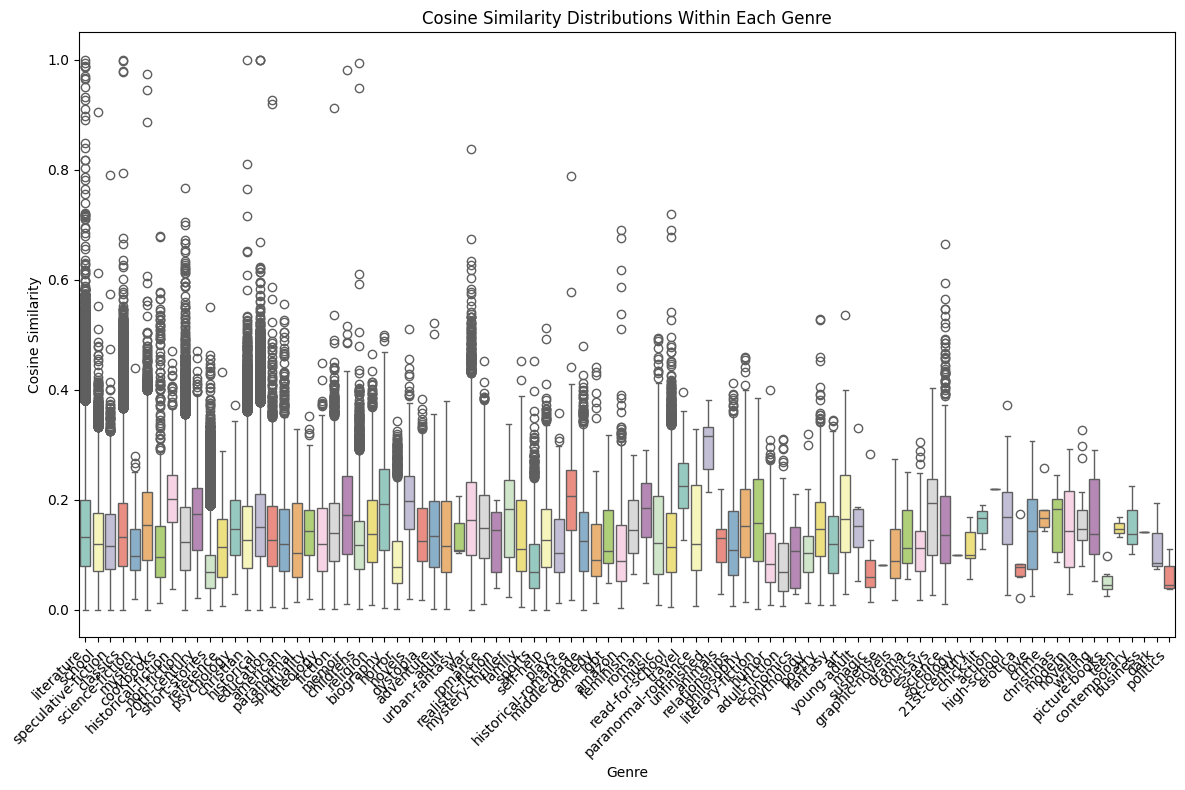

Average Cosine Similarity by Genre:
literature: 0.144
school: 0.128
speculative-fiction: 0.129
classics: 0.140
science-fiction: 0.111
mystery: 0.154
cookbooks: 0.144
historical-fiction: 0.201
non-fiction: 0.135
20th-century: 0.171
short-stories: 0.077
reference: 0.117
psychology: 0.157
christian: 0.139
historical: 0.158
education: 0.142
american: 0.135
paranormal: 0.133
spirituality: 0.144
theology: 0.133
fiction: 0.145
memoir: 0.180
childrens: 0.122
religion: 0.149
biography: 0.189
horror: 0.096
novels: 0.193
dystopia: 0.140
adventure: 0.140
adult: 0.134
urban-fantasy: 0.140
war: 0.171
romance: 0.155
realistic-fiction: 0.127
mystery-thriller: 0.168
family: 0.136
sports: 0.087
self-help: 0.133
plays: 0.122
historical-romance: 0.203
middle-grade: 0.128
comedy: 0.117
lgbt: 0.143
amazon: 0.110
feminism: 0.154
roman: 0.182
music: 0.144
read-for-school: 0.129
travel: 0.232
paranormal-romance: 0.146
unfinished: 0.301
animals: 0.123
relationships: 0.127
philosophy: 0.164
literary-fiction: 0.1

In [ ]:
def get_primary_genre(x):
    # If it's already a list, return the first element if possible.
    if isinstance(x, list) and len(x) > 0:
        return x[0]
    # If it's a string, try to evaluate it.
    elif isinstance(x, str):
        try:
            val = ast.literal_eval(x)
            if isinstance(val, list) and len(val) > 0:
                return val[0]
            else:
                return None
        except Exception:
            return None
    else:
        return None

dtm_df = df_dtm.copy()  # if not already
dtm_df['primary_genre'] = dtm_df['genres'].apply(get_primary_genre)

# Identify term columns (all columns except 'genres' and 'primary_genre')
term_columns = [col for col in dtm_df.columns if col not in ['genres', 'primary_genre']]
# Extract the TF-IDF matrix as a dense numpy array 
X = scipy.sparse.csr_matrix(dtm_df[term_columns].values)

# # --- Step 1: Compute Pairwise Cosine Similarities Within Each Genre ---
genre_cosine_sim = {}
unique_genres = dtm_df['primary_genre'].dropna().unique()

for genre in unique_genres:
    # Get indices for documents with this primary genre.
    indices = dtm_df.index[dtm_df['primary_genre'] == genre].tolist()
    if len(indices) < 2:
        # Not enough documents to compute pairwise similarity.
        continue
    # Extract the subset of the TF-IDF matrix.
    X_genre = X[indices]
    # Compute pairwise cosine similarity for these documents.
    cos_sim = cosine_similarity(X_genre)
    # Exclude self-similarity by taking the upper triangle (k=1).
    triu_idx = np.triu_indices_from(cos_sim, k=1)
    similarities = cos_sim[triu_idx]
    genre_cosine_sim[genre] = similarities


rows = []
for genre, sims in genre_cosine_sim.items():
    for sim in sims:
        rows.append({'Genre': genre, 'CosineSimilarity': sim})
df_sim = pd.DataFrame(rows)

# Visualize the Cosine Similarity Distributions by Genre ---
plt.figure(figsize=(12, 8))
sns.boxplot(x='Genre', y='CosineSimilarity', data=df_sim, palette="Set3")
plt.title("Cosine Similarity Distributions Within Each Genre")
plt.xlabel("Genre")
plt.ylabel("Cosine Similarity")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

# Compute Average Cosine Similarity per Genre
avg_sim_by_genre = {genre: np.mean(sims) for genre, sims in genre_cosine_sim.items()}
print("Average Cosine Similarity by Genre:")
for genre, avg_sim in avg_sim_by_genre.items():
    print(f"{genre}: {avg_sim:.3f}")